# Using our VQA system

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from transformers import ViTModel, AutoModel, AutoModelForCausalLM, AutoTokenizer
from PIL import Image
import torch
import torch.nn as nn
from transformers import AutoModel, ViTModel, AutoModelForCausalLM
import urllib.request

from tqdm.auto import tqdm
import torch.nn.functional as F

import matplotlib.pyplot as plt
from transformers import ViTModel, ViTFeatureExtractor, AutoTokenizer, AutoModel, AutoModelForCausalLM


In [3]:
DECODER_MODEL = 'gpt2'
TEXT_ENCODER_MODEL = 'distilbert-base-uncased'
IMAGE_ENCODER_MODEL = "facebook/dino-vitb16"

In [4]:
text_tokenizer = AutoTokenizer.from_pretrained(TEXT_ENCODER_MODEL)
decoder_tokenizer = AutoTokenizer.from_pretrained(DECODER_MODEL)
decoder_tokenizer.pad_token = decoder_tokenizer.eos_token
image_feature_extractor = ViTFeatureExtractor.from_pretrained(IMAGE_ENCODER_MODEL)

C:\Users\sinan\anaconda3\envs\Torch2\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [5]:
from PIL import Image

def retrieve_image(image_file):
    if 'http' in image_file:
        urllib.request.urlretrieve(image_file, "temp.jpg")
        image_file = 'temp.jpg'
    try:
        image = Image.open(image_file)
        return image
    except:
        return None
    
def preprocess_image(image):
    # Open the image if the input is a file path
    if type(image) == str:
        img = Image.open(image)
    else:
        img = image

    # Check the number of channels in the image and convert to RGB if necessary
    if img.mode == 'L':  # 'L' stands for grayscale mode
        img_rgb = img.convert('RGB')
    else:
        img_rgb = img

    return img_rgb

In [6]:
class MultiModalModel(nn.Module):
    def __init__(self, text_encoder_model, image_encoder_model, decoder_model, freeze=None, load_from=None):
        super(MultiModalModel, self).__init__()

        # Initialize text and image encoders
        self.text_encoder = AutoModel.from_pretrained(text_encoder_model)
        self.image_encoder = ViTModel.from_pretrained(image_encoder_model)

        # Initialize the GPT-2 decoder
        self.decoder = AutoModelForCausalLM.from_pretrained(
            decoder_model, add_cross_attention=True, tie_word_embeddings=False
        )

        # Initialize linear layers for projecting encoded features
        self.text_projection = nn.Linear(self.text_encoder.config.hidden_size, self.decoder.config.hidden_size)
        self.image_projection = nn.Linear(self.image_encoder.config.hidden_size, self.decoder.config.hidden_size)
        
        # Freeze specified encoders if required
        if load_from:
            # Load the saved model checkpoint
            checkpoint = torch.load(load_from)
            checkpoint = {k.replace("module.", ""): v for k, v in checkpoint.items()}

            # Load the state dictionary into the model
            self.load_state_dict(checkpoint)
        else:
            self.freeze(freeze)

    def freeze(self, freeze):
        if not freeze:
            return

        print('Freezing...')
        if freeze in ('encoders', 'all') or 'text_encoder' in freeze:
            print('Freezing text encoder')
            for param in self.text_encoder.parameters():
                param.requires_grad = False

        if freeze in ('encoders', 'all') or 'image_encoder' in freeze:
            print('Freezing image encoder')
            for param in self.image_encoder.parameters():
                param.requires_grad = False
                
        if freeze in ('decoder', 'all'):
            print('Freezing decoder (except for cross attention)')
            for name, param in self.decoder.named_parameters():
                if "crossattention" not in name:
                    param.requires_grad = False

    def check_input(self, tensor, tensor_name):
        if torch.isnan(tensor).any() or torch.isinf(tensor).any():
            print(f"NaN or infinite values found in {tensor_name}")

    def encode_text(self, input_text, attention_mask):
        self.check_input(input_text, "input_text")
        text_encoded = self.text_encoder(input_text, attention_mask=attention_mask).last_hidden_state.mean(dim=1)
        return self.text_projection(text_encoded)

    def encode_image(self, input_image):
        self.check_input(input_image, "input_image")
        image_encoded = self.image_encoder(input_image).last_hidden_state.mean(dim=1)
        return self.image_projection(image_encoded)

    def forward(self, input_text, input_image, decoder_input_ids, attention_mask, labels=None):
        self.check_input(decoder_input_ids, "decoder_input_ids")

        # Encode text and image
        text_projected = self.encode_text(input_text, attention_mask)
        image_projected = self.encode_image(input_image)

        # Combine encoded features
        combined_features = (text_projected + image_projected) / 2
        if labels is not None:
            labels = torch.where(labels == decoder_tokenizer.pad_token_id, -100, labels)

        # Decode with GPT-2
        decoder_outputs = self.decoder(
            input_ids=decoder_input_ids,
            labels=labels,
            encoder_hidden_states=combined_features.unsqueeze(1)
        )
        return decoder_outputs

    def generate(self, image, questions, max_text_length=5):
        # Encode text and image
        image = retrieve_image(image)
        image_input = image_feature_extractor(images=[preprocess_image(image)], return_tensors="pt")
        input_image = image_input["pixel_values"]
        image_projected = self.encode_image(input_image)
            
        
        for question in questions:
            i = text_tokenizer(question, return_tensors='pt')
            text_projected = self.encode_text(i['input_ids'], i['attention_mask'])
        

            # Combine encoded features
            combined_features = (text_projected + image_projected) / 2

            generated_so_far = torch.LongTensor([[decoder_tokenizer.bos_token_id]])
            with torch.no_grad():
                for _ in tqdm(range(max_text_length)):

                    decoder_outputs = self.decoder(
                        input_ids=generated_so_far,
                        encoder_hidden_states=combined_features.unsqueeze(1),
                        output_attentions=True
                    )

                    next_token_logits = decoder_outputs.logits[:, -1, :]
                    next_token_probs = F.softmax(next_token_logits, dim=-1)
                    next_token = next_token_logits.argmax(-1)
                    confidence = next_token_probs[0, next_token].item()
                    print("Next token:", decoder_tokenizer.decode(next_token), "Confidence:", confidence)
                    generated_so_far = torch.cat((generated_so_far, next_token.unsqueeze(0)), dim=1)
            print(question, decoder_tokenizer.decode(generated_so_far[0]))

        return image, decoder_outputs, input_image
        

In [7]:
trained_model = MultiModalModel(
    image_encoder_model=IMAGE_ENCODER_MODEL, text_encoder_model=TEXT_ENCODER_MODEL,
    decoder_model=DECODER_MODEL, load_from="vqa_custom/pytorch_model.bin")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and i

In [8]:
from datasets import load_from_disk
val = load_from_disk('vqa_train_dataset')

In [9]:
v = val[1]
v

{'image_id': 458752,
 'question_id': 458752001,
 'question': 'What position is this man playing?',
 'answer': '<|endoftext|> pitcher<|endoftext|>',
 'all_answers': ['pitcher',
  'catcher',
  'pitcher',
  'pitcher',
  'pitcher',
  'pitcher',
  'pitcher',
  'pitcher',
  'pitcher',
  'pitcher'],
 'image': 'train2014/COCO_train2014_000000458752.jpg'}

  0%|          | 0/1 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Next token:  baseball Confidence: 0.6964899301528931
what sport is this person playing? <|endoftext|> baseball


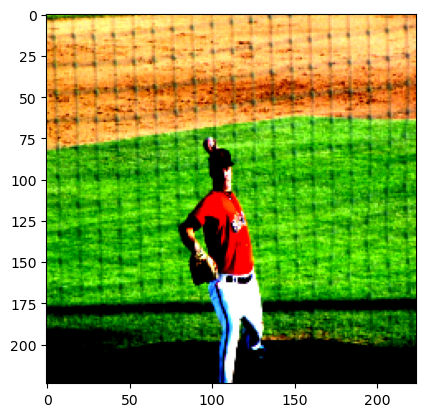

In [10]:
image, outputs, processed_image = trained_model.generate(v['image'], ['what sport is this person playing?'], max_text_length=1)
plt.imshow(processed_image.squeeze(0).permute(1, 2, 0))

  0%|          | 0/1 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Next token:  soccer Confidence: 0.6508514285087585
what sport is this person playing? <|endoftext|> soccer


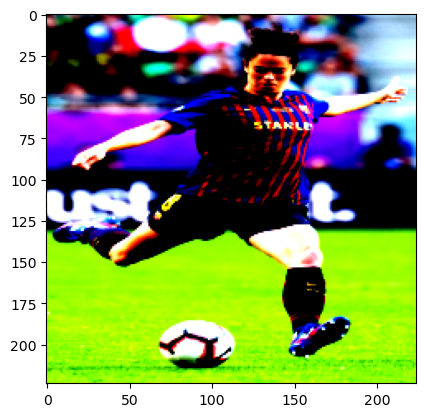

In [13]:
image, outputs, processed_image = trained_model.generate(
    'https://upload.wikimedia.org/wikipedia/commons/2/2d/2019-05-18_Fu%C3%9Fball%2C_Frauen%2C_UEFA_Women%27s_Champions_League%2C_Olympique_Lyonnais_-_FC_Barcelona_StP_1192_LR10_by_Stepro%28Cropped%29.jpg', 
    ['what sport is this person playing?'], max_text_length=1)
plt.imshow(processed_image.squeeze(0).permute(1, 2, 0))